# In this notebook we will crate multicalss calssification model using pytorch

In [ ]:
#importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [ ]:
import torch
from torch import nn


torch.__version__

'2.8.0+cu126'

In [ ]:
#loade dataset of multiclass
#we will use scikit learn blob dataset | it has mulitple class

from sklearn.datasets import make_blobs

#setting the hyperparameter
Num_class = 4
Num_features = 2

#create data

X_blob , y_blob = make_blobs(
    n_samples=1000,

    n_features=Num_features,

    centers=Num_class,

    cluster_std=1.7, # give the clusters a little shake up (try changing this to 1.0, the default)

    random_state = 42
)

X_blob.shape , y_blob.shape



((1000, 2), (1000,))

In [ ]:
X_blob[:5] ,  y_blob[:5] , type(X_blob)

(array([[-8.35673838,  6.88338446],
        [-5.61806506, -6.37131221],
        [-5.93047144, -6.75090043],
        [ 3.85896531,  0.52843426],
        [ 4.19857354, -0.58217334]]),
 array([3, 2, 2, 1, 1]),
 numpy.ndarray)

In [ ]:
#turning data into tensors

X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) #because in multiclass classification , we use CrossEntropyLoss and it expect y val to be torch LongTensor

type(X_blob) , type(y_blob)

(torch.Tensor, torch.Tensor)

In [ ]:
#splitting data to train and test set

from sklearn.model_selection import train_test_split

X_train , X_test, y_train, y_test = train_test_split(X_blob , y_blob , test_size= 0.2 , random_state=42)

X_train.shape , X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

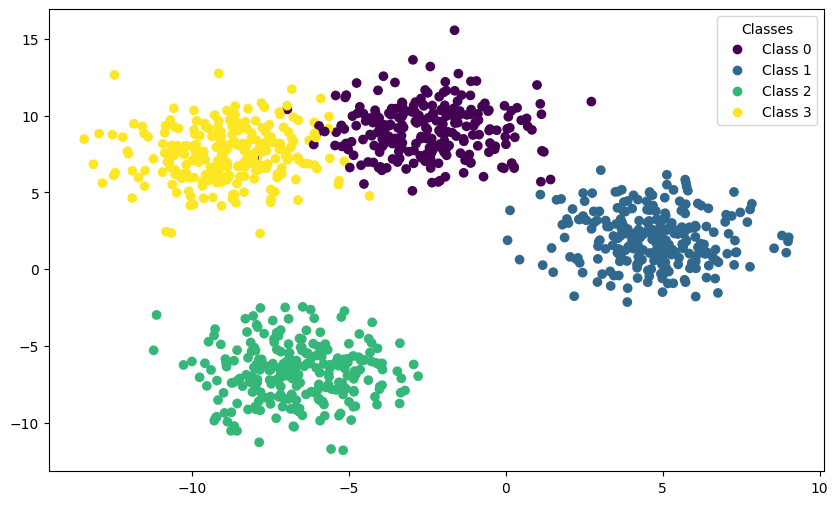

In [ ]:

plt.figure(figsize=(10,6))
scatter = plt.scatter(
      X_blob[:, 0],
      X_blob[:, 1],
      c=y_blob,

)

#just to show color val
# Create a legend
# Get unique labels from y_blob
labels = np.unique(y_blob)
# Generate legend elements
handles = [plt.Line2D([], [], marker="o", color=scatter.cmap(scatter.norm(label)),
                      linestyle="", label=f"Class {label}") for label in labels]

plt.legend(handles=handles, title="Classes")
plt.show()


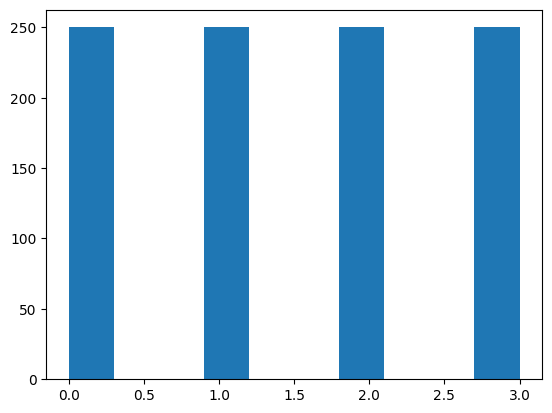

In [ ]:
#so there is 4 types of num in y_blob
plt.hist(y_blob)
plt.show()

In [ ]:
#device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
def accuracy_fn(y_preds , y_true):
  accurate = torch.eq(y_preds , y_true).sum().item()
  return (accurate / len(y_preds)) * 100

In [ ]:
#building the model
#here we will build the model using nn.sequiential that exactly same as doing self.layer

class BlobModel(nn.Module):
  def __init__(self , input_features , output_features , hidden_units = 8):

    super().__init__()

    self.Linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features , out_features = hidden_units),
        # nn.ReLU(), #we don't need activation function | see why in last
        nn.Linear(in_features = hidden_units , out_features = hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features = hidden_units , out_features = output_features)
    )

  def forward(self , x):
    return self.Linear_layer_stack(x)


In [ ]:
#
torch.manual_seed(42)
model_0 = BlobModel(
    input_features=2,
    output_features=4
)
model_0 = model_0.to(device)

model_0

BlobModel(
  (Linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
#creating loss and optimizer

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_0.parameters() , lr = 0.1)

In [ ]:
#just seeing outputs

y_logits = model_0(X_train.to(device))
y_logits[:5] , y_logits.shape

(tensor([[-1.2957, -0.6730, -1.5046, -0.7061],
         [ 0.2205, -1.5532,  0.0400,  1.1597],
         [ 2.9424,  0.9515,  3.4023,  1.4323],
         [ 1.9086,  0.2695,  2.1642,  1.1259],
         [ 0.5885, -1.2066,  0.4957,  1.1906]], grad_fn=<SliceBackward0>),
 torch.Size([800, 4]))

The outputs are logits.

We will apply activation function(softmax)


The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.



In [ ]:
y_preds_prob = torch.softmax(y_logits , dim = 1)
y_preds_prob[:5]

tensor([[0.1825, 0.3402, 0.1481, 0.3291],
        [0.2192, 0.0372, 0.1830, 0.5606],
        [0.3400, 0.0464, 0.5385, 0.0751],
        [0.3398, 0.0660, 0.4388, 0.1554],
        [0.2562, 0.0426, 0.2335, 0.4678]], grad_fn=<SliceBackward0>)

These are probability. if we sum up any row, it will be 1


In [ ]:
torch.sum(y_preds_prob[0])

tensor(1., grad_fn=<SumBackward0>)

In [ ]:
y_preds = torch.argmax(y_preds_prob , dim = 1).type(torch.float32)
y_preds[:5] , y_preds.dtype

(tensor([1., 3., 2., 2., 3.]), torch.float32)

In [ ]:
#now training

torch.manual_seed(42)

X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

epochs = 1001

for epoch in range(epochs):

  model_0.train()

  y_logits = model_0(X_train)

  y_preds = torch.softmax(y_logits , dim = 1).argmax(dim = 1) #or we could simple use y_logits.argmax(dim = 1) as order will remain same

  acc = accuracy_fn(y_preds , y_train)

  loss = loss_fn(y_logits , y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()

  with torch.inference_mode():
    test_logits = model_0(X_test)

    test_pred = torch.softmax(test_logits , dim = 1).argmax(dim = 1)

    test_acc = accuracy_fn(test_pred , y_test)

    test_loss = loss_fn(test_logits , y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | train acc: {acc}% | train loss : {loss} | test acc : {test_acc}%| test loss : {test_loss} ")

Epoch: 0 | train acc: 64.0% | train loss : 1.0464191436767578 | test acc : 94.0%| test loss : 0.5856935381889343 
Epoch: 100 | train acc: 98.375% | train loss : 0.05245106667280197 | test acc : 99.0%| test loss : 0.04043138399720192 
Epoch: 200 | train acc: 98.375% | train loss : 0.04813896119594574 | test acc : 99.0%| test loss : 0.03507941588759422 
Epoch: 300 | train acc: 98.375% | train loss : 0.04668669402599335 | test acc : 99.0%| test loss : 0.0331798754632473 
Epoch: 400 | train acc: 98.375% | train loss : 0.045769378542900085 | test acc : 99.0%| test loss : 0.03200453147292137 
Epoch: 500 | train acc: 98.375% | train loss : 0.04503335431218147 | test acc : 99.0%| test loss : 0.03108690306544304 
Epoch: 600 | train acc: 98.375% | train loss : 0.04438122734427452 | test acc : 99.0%| test loss : 0.030293714255094528 
Epoch: 700 | train acc: 98.5% | train loss : 0.04377688840031624 | test acc : 99.0%| test loss : 0.029574505984783173 
Epoch: 800 | train acc: 98.5% | train loss : 0

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


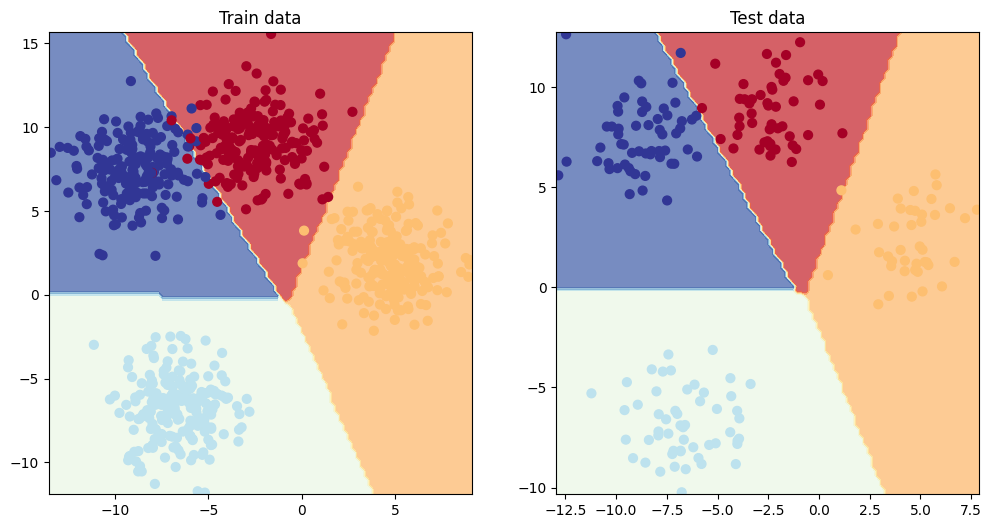

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model_0 , X_train , y_train)
plt.title('Train data')

plt.subplot(1,2,2)
plot_decision_boundary(model_0 , X_test , y_test)
plt.title('Test data')

plt.show()

---

>in sklearn make_circles datasets we needed activation function like relu otherwise model just score 50%
we see plotting decision_boundary that it creates just straight linear line across dataset.
when we use relu in model hidden layer, it increases to 99
so in sklearn make_blob dataset(multi class: 4 class) do we need any activation function in model hidden layer. or just linear line can handle it

<br>

---

### 1. `make_circles`

* Data looks like **nested rings** (non-linear).
* A simple linear classifier (no activation, just `Linear -> Linear`) can only draw straight lines → can’t separate rings.
* That’s why you got ~50% accuracy and a straight decision boundary.
* Adding **ReLU (or any non-linear activation)** gives the network the ability to learn non-linear decision boundaries → accuracy shoots up (~99%).

---

### 2. `make_blobs` (4 classes)

* Data looks like **Gaussian blobs** in feature space.
* These blobs are **linearly separable** (or very close to it).
* That means a **linear classifier (no hidden layers, no activation)** is usually enough.
* You can solve it with **logistic regression / softmax regression** directly.
* If you add hidden layers + ReLU, it will still work, but it’s overkill — the model just learns linear separators anyway.

---

### 🚀 Rule of Thumb

* **Linearly separable dataset (like `make_blobs`)** → No need for hidden activations, a linear classifier works.
* **Non-linearly separable dataset (like `make_circles`, `make_moons`)** → Need non-linear activations in hidden layers to learn curved boundaries.

---

### Visualization intuition

* With `make_circles`, if you plot a decision boundary from a **linear model**, it’s always a straight line (bad).
* With `make_blobs`, that same straight line is actually enough to separate clusters (good).

---

👉 So for your `make_blob` (4-class) dataset:

* You don’t **need** activations in hidden layers — a simple `Linear -> Softmax` should already reach high accuracy.
* Adding ReLU won’t hurt, but it’s unnecessary unless you add more complexity (like overlapping blobs or noisy data).

---

Would you like me to show you a **side-by-side decision boundary plot**:

* (a) `make_blobs` with linear model
* (b) `make_circles` with linear vs ReLU
  so you can visually compare why one works and the other doesn’t?



---
>how this is linear. one straight line can't divide 4 cluster data accuately . if you say 4 straight line was used to separate , then  in make_circle dataset we could use many small straight line join together to make a circle to separate them. am i right ? if yes then why our model could make it even we added many hidden layers. if not then where am i tripping off

---


## 1. What “linear” means in neural nets

* A network with only `Linear` (fully connected) layers and **no nonlinear activation** is still **just a linear transformation**.
* Why? Because stacking linear layers collapses into **one linear transformation**:

$$
W_2(W_1x + b_1) + b_2 = (W_2W_1)x + (W_2b_1 + b_2)
$$

So even with multiple `Linear` layers, without activations, the model can only represent a **single straight-line (hyperplane) decision boundary per class**.

👉 That’s why `make_circles` fails without ReLU — you can’t bend a line into a circle with only linear ops.

---

## 2. Why `make_blobs` works with a linear model

For `make_blobs` (e.g. 4 classes), you’re right: **one straight line can’t separate 4 clusters**.
But here’s the trick:

* For *multiclass classification* with `CrossEntropyLoss`, the model doesn’t just learn one line.
* A `Linear -> Softmax` model learns **one separating hyperplane per class**.
* With 4 classes, the model effectively learns **4 linear boundaries** that together carve up the space.

👉 That’s why it works fine on blobs — you don’t need curved boundaries, just enough planes.

---

## 3. Why your “many small straight lines making a circle” idea doesn’t work without nonlinearity

Your intuition is solid 💯, but here’s the catch:

* To approximate a circle with many small straight lines, you need a **piecewise linear function**.
* Neural nets can do this *only if you insert nonlinear activations (like ReLU)*.
* Without ReLU (or similar), the network collapses to one global linear function → no “pieces.”
* With ReLU, each hidden unit introduces a “kink,” letting the model stitch together many line segments. That’s how a net can approximate a circle.

---

## 4. So where’s the difference?

* `make_blobs` → linearly separable with multiple hyperplanes (so linear model works).
* `make_circles` → **not linearly separable**, needs curved/piecewise linear boundaries → requires nonlinear activation.

---

✅ **Summary**

* More `Linear` layers without activation don’t add power → still one straight separator per class.
* Adding **ReLU** breaks linearity → allows many piecewise linear cuts → can approximate circles, spirals, moons, etc.

---

Would you like me to **draw the decision boundaries** for:

1. `make_blobs` (linear model)
2. `make_circles` (linear vs ReLU)

so you can *see* exactly why the difference happens?


# when we used relu



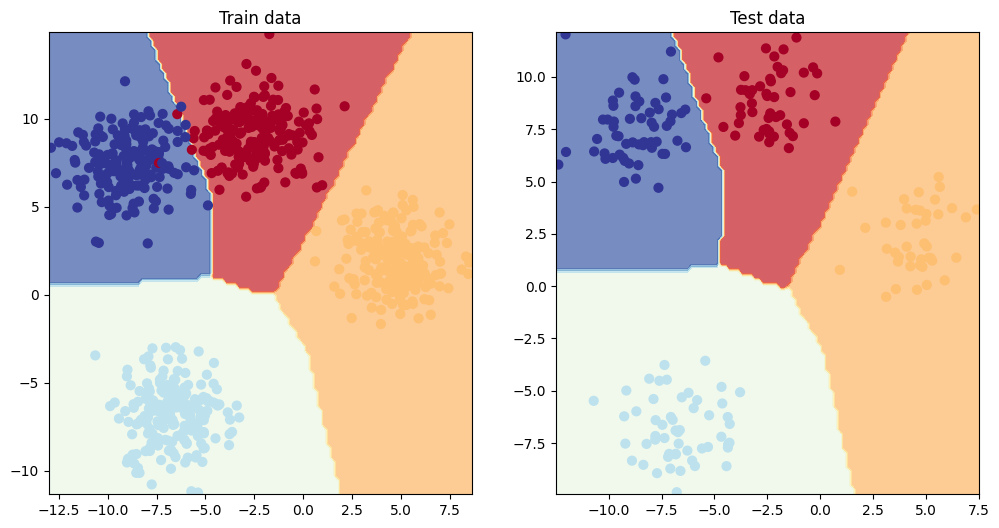

# When we didn't use relu

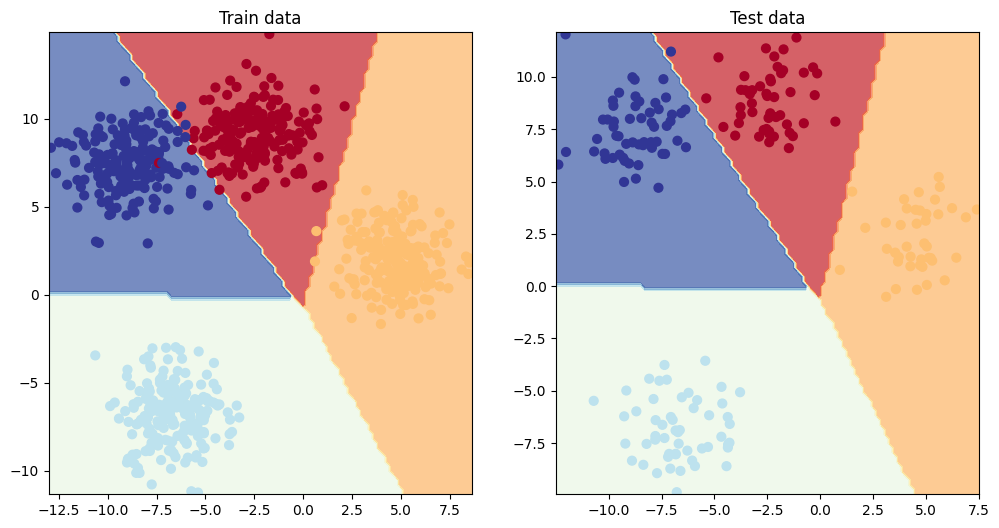